In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression

from sklearn.ensemble import RandomForestRegressor


from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, cross_val_score

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/seoul-bike-rental-ai-pro-iti/sample_submission.csv
/kaggle/input/seoul-bike-rental-ai-pro-iti/train.csv
/kaggle/input/seoul-bike-rental-ai-pro-iti/test.csv


We are provided hourly rental data along with weather data. We have to predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.

### Data fields:
- ID - an ID for this instance
- Date - year-month-day
- Hour - Hour of he day
- Temperature - Temperature in Celsius
- Humidity - %
- Windspeed - m/s
- Visibility - 10m
- Dew point temperature - Celsius
- Solar radiation - MJ/m2
- Rainfall - mm
- Snowfall - cm
- Seasons - Winter, Spring, Summer, Autumn
- Holiday - Holiday/No holiday
- Functional Day - NoFunc(Non Functional Hours), Fun(Functional hours)
- y - Rented Bike count (Target), Count of bikes rented at each hour

In [2]:
train_df= pd.read_csv(os.path.join(dirname, 'train.csv'), parse_dates = ['Date'])
test_df= pd.read_csv(os.path.join(dirname, 'test.csv'), parse_dates = ['Date'])
# info about df like type ..
train_df.head()

,ID,Date,y,Hour,Temperature(�C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(�C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,0,2017-01-12,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,1,2017-01-12,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,2,2017-01-12,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,3,2017-01-12,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,4,2017-01-12,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [3]:
test_df.count()

ID                           3000
Date                         3000
Hour                         3000
Temperature(�C)              3000
Humidity(%)                  3000
Wind speed (m/s)             3000
Visibility (10m)             3000
Dew point temperature(�C)    3000
Solar Radiation (MJ/m2)      3000
Rainfall(mm)                 3000
Snowfall (cm)                3000
Seasons                      3000
Holiday                      3000
Functioning Day              3000
dtype: int64

In [4]:
# numerice columns in our df 
numerics = ['int64', 'float64']
train_df.select_dtypes(include=numerics).columns

Index(['ID', 'y', 'Hour', 'Temperature(�C)', 'Humidity(%)', 'Wind speed (m/s)',
       'Visibility (10m)', 'Dew point temperature(�C)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)'],
      dtype='object')

In [5]:
#drop duplicates in our df 
print(f"Before Drop Duplicates : {train_df.shape}")
train_df= train_df.drop_duplicates()
test_df= test_df.drop_duplicates()
print(f"After Drop Duplicates : {train_df.shape}")
print("We noticed that df don't have any duplicates :)")

Before Drop Duplicates : (5760, 15)
After Drop Duplicates : (5760, 15)
We noticed that df don't have any duplicates :)


## Another way to Convert our date columns to datetime
train_df['Date'] = pd.to_datetime(train_df['Date'], format="%d/%m/%Y")
train_df['Date'].head()

In [6]:
# Extract day, month and year from date column in train_df
train_df['dayofweek']=train_df['Date'].dt.dayofweek
#train_df['month']=train_df['Date'].dt.month
# train_df['dayofyear']=train_df['Date'].dt.dayofyear

# Extract day, month and year from date column in test_df
test_df['dayofweek']=test_df['Date'].dt.dayofweek
# test_df['dayofyear']=test_df['Date'].dt.dayofyear

In [7]:
train_df = train_df[train_df['Functioning Day'] != 'No']

In [8]:
train_df.count()

ID                           5513
Date                         5513
y                            5513
Hour                         5513
Temperature(�C)              5513
Humidity(%)                  5513
Wind speed (m/s)             5513
Visibility (10m)             5513
Dew point temperature(�C)    5513
Solar Radiation (MJ/m2)      5513
Rainfall(mm)                 5513
Snowfall (cm)                5513
Seasons                      5513
Holiday                      5513
Functioning Day              5513
dayofweek                    5513
dtype: int64

In [9]:
train_df['working_day'] = (train_df['Date'].dt.dayofweek < 5).astype(np.int)
test_df['working_day'] = (test_df['Date'].dt.dayofweek < 5).astype(np.int)

In [10]:
train_df['work_st_en'] = ((train_df['Date'].dt.dayofweek < 5) & 
                         (((train_df['Hour'] >= 7) &  (train_df['Hour'] <= 9) )|
                         ((train_df['Hour'] >= 17) &  (train_df['Hour'] <= 19)))).astype(np.int)

test_df['work_st_en'] = ((test_df['Date'].dt.dayofweek < 5) & 
                         (test_df['Hour'] >= 7) &  (test_df['Hour'] <= 9) &
                         (test_df['Hour'] >= 17) &  (test_df['Hour'] <= 19)).astype(np.int)

In [11]:
# use this encoder to encode

from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
le = LabelEncoder()

def encode_columns(dataframe, lst_of_col):
    for col in lst_of_col:
        dataframe[col] = le.fit_transform(dataframe[col].values)
        
lst_of_col = ['Seasons',
              'Holiday']

encode_columns(train_df, lst_of_col)
encode_columns(test_df, lst_of_col)

In [12]:
train_df['Wind speed (m/s)'] = np.log1p(train_df['Wind speed (m/s)'])
test_df['Wind speed (m/s)'] = np.log1p(test_df['Wind speed (m/s)'])

In [13]:
train_df['Solar Radiation (MJ/m2)'] = np.sqrt(train_df['Solar Radiation (MJ/m2)'])
test_df['Solar Radiation (MJ/m2)'] = np.sqrt(test_df['Solar Radiation (MJ/m2)'])

In [14]:
train_df['Rainfall(mm)'] = train_df.rolling(2, min_periods=1)['Rainfall(mm)'].mean()
test_df['Rainfall(mm)'] = test_df.rolling(2, min_periods=1)['Rainfall(mm)'].mean()

train_df['dryness'] = 1 / (train_df['Rainfall(mm)'] + 1)
test_df['dryness'] = 1 / (test_df['Rainfall(mm)'] + 1)

In [15]:
train_df['Snowfall (cm)'] = train_df.rolling(8, min_periods=1)['Snowfall (cm)'].mean()
test_df['Snowfall (cm)'] = test_df.rolling(8, min_periods=1)['Snowfall (cm)'].mean()

train_df['snowing'] = (train_df['Snowfall (cm)'] > 0).astype(np.int)
test_df['snowing'] = (test_df['Snowfall (cm)'] > 0).astype(np.int)

In [16]:
train_df['invis'] = 2000 - train_df['Visibility (10m)']
test_df['invis'] = 2000 - test_df['Visibility (10m)']


In [17]:
train_df.skew()

ID                            0.048409
y                             1.138949
Hour                         -0.001935
Temperature(�C)              -0.144444
Humidity(%)                   0.127140
Wind speed (m/s)              0.007737
Visibility (10m)             -0.814488
Dew point temperature(�C)    -0.285626
Solar Radiation (MJ/m2)       0.802236
Rainfall(mm)                 10.989264
Snowfall (cm)                 8.012216
Seasons                      -0.067800
Holiday                      -4.751443
dayofweek                    -0.006982
working_day                  -0.923683
work_st_en                    1.689445
dryness                      -4.480887
snowing                       4.443433
invis                         0.814488
dtype: float64

<AxesSubplot:>

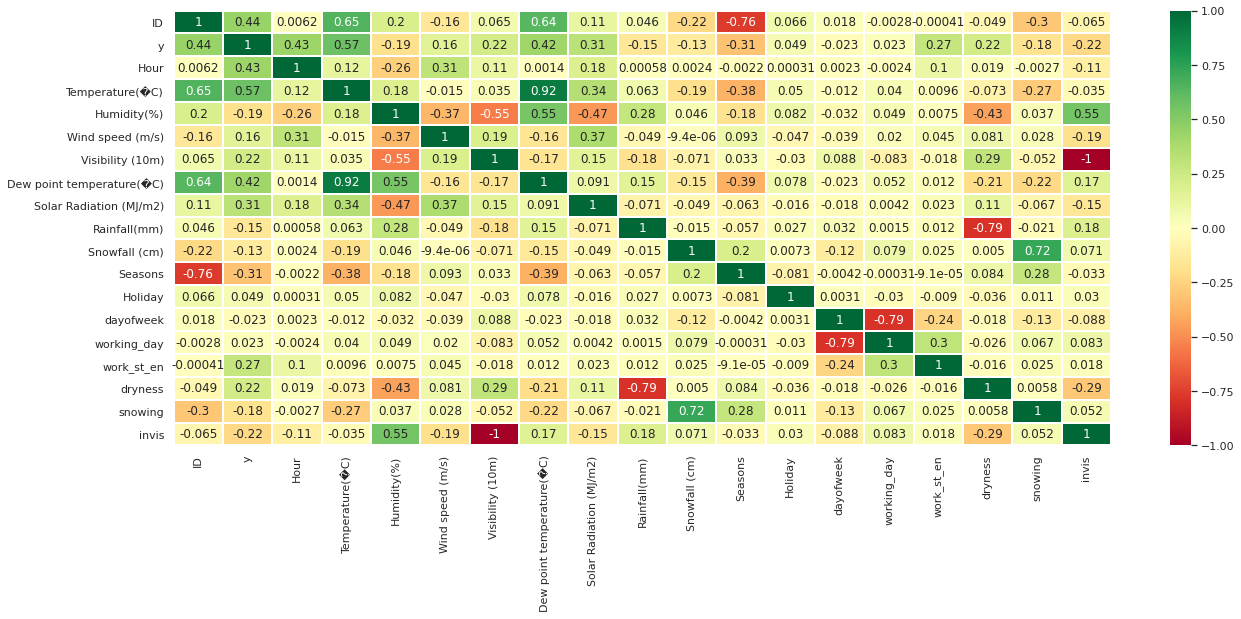

In [18]:
# dispaly correlation between features or columns in data 
np.random.seed(0)
sns.set_theme()
fig, ax = plt.subplots(figsize = (21, 8))
sns.heatmap(train_df.corr(), cmap ='RdYlGn', linewidths = 0.3, annot = True)

array([[<AxesSubplot:xlabel='y', ylabel='y'>,
        <AxesSubplot:xlabel='Rainfall(mm)', ylabel='y'>,
        <AxesSubplot:xlabel='Snowfall (cm)', ylabel='y'>,
        <AxesSubplot:xlabel='Solar Radiation (MJ/m2)', ylabel='y'>,
        <AxesSubplot:xlabel='Hour', ylabel='y'>],
       [<AxesSubplot:xlabel='y', ylabel='Rainfall(mm)'>,
        <AxesSubplot:xlabel='Rainfall(mm)', ylabel='Rainfall(mm)'>,
        <AxesSubplot:xlabel='Snowfall (cm)', ylabel='Rainfall(mm)'>,
        <AxesSubplot:xlabel='Solar Radiation (MJ/m2)', ylabel='Rainfall(mm)'>,
        <AxesSubplot:xlabel='Hour', ylabel='Rainfall(mm)'>],
       [<AxesSubplot:xlabel='y', ylabel='Snowfall (cm)'>,
        <AxesSubplot:xlabel='Rainfall(mm)', ylabel='Snowfall (cm)'>,
        <AxesSubplot:xlabel='Snowfall (cm)', ylabel='Snowfall (cm)'>,
        <AxesSubplot:xlabel='Solar Radiation (MJ/m2)', ylabel='Snowfall (cm)'>,
        <AxesSubplot:xlabel='Hour', ylabel='Snowfall (cm)'>],
       [<AxesSubplot:xlabel='y', ylabel='Solar R

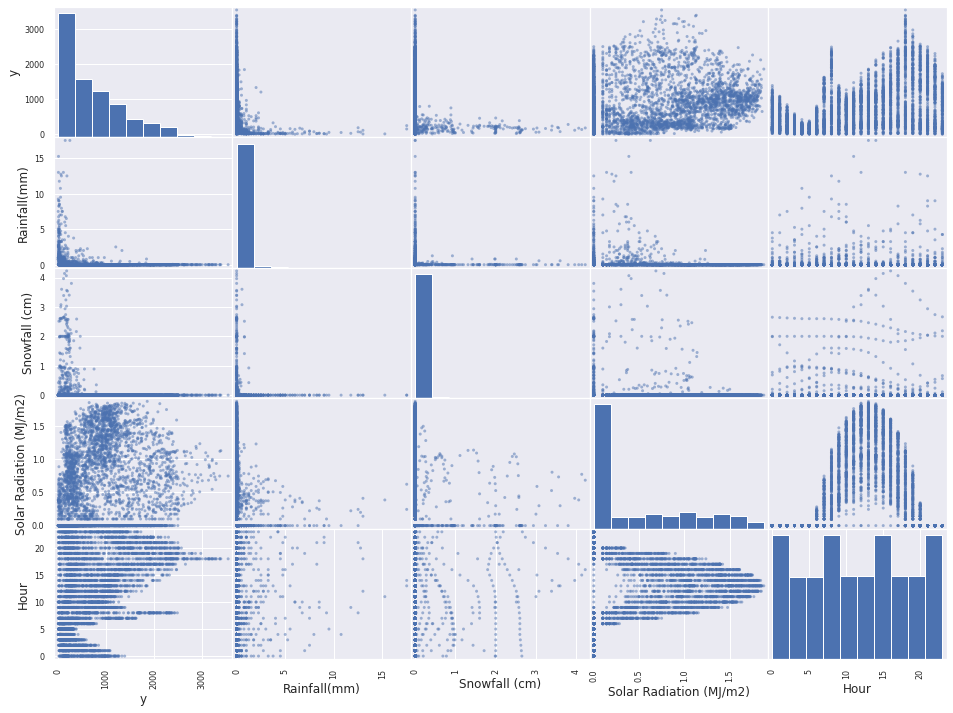

In [19]:
# display Scatter of some columns in df 
attributes = ['y', 'Rainfall(mm)', 'Snowfall (cm)','Solar Radiation (MJ/m2)','Hour']
#category = ['y','Seasons','Holiday', 'Functioning Day','Temperature(�C)','month']
scatter_matrix(train_df[attributes], figsize=(16, 12))
#train_df.hist(figsize=(16, 12))

In [20]:
# display corr in descending order between y and remaining columns
corr_matrix = train_df.corr()
corr_matrix["y"].sort_values(ascending=False)[1:]

Temperature(�C)              0.574191
ID                           0.438407
Hour                         0.425788
Dew point temperature(�C)    0.418591
Solar Radiation (MJ/m2)      0.313867
work_st_en                   0.274808
dryness                      0.222827
Visibility (10m)             0.222313
Wind speed (m/s)             0.155980
Holiday                      0.048611
working_day                  0.023248
dayofweek                   -0.022840
Snowfall (cm)               -0.131891
Rainfall(mm)                -0.148479
snowing                     -0.176859
Humidity(%)                 -0.192091
invis                       -0.222313
Seasons                     -0.314052
Name: y, dtype: float64

In [21]:
discrete_features = train_df.drop(['ID', 'Date', 'y'], axis = 1).dtypes == int

In [22]:
train_df.isna().sum()

ID                           0
Date                         0
y                            0
Hour                         0
Temperature(�C)              0
Humidity(%)                  0
Wind speed (m/s)             0
Visibility (10m)             0
Dew point temperature(�C)    0
Solar Radiation (MJ/m2)      0
Rainfall(mm)                 0
Snowfall (cm)                0
Seasons                      0
Holiday                      0
Functioning Day              0
dayofweek                    0
working_day                  0
work_st_en                   0
dryness                      0
snowing                      0
invis                        0
dtype: int64

In [23]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

#mi_scores = make_mi_scores(train_df.drop(['ID', 'Date', 'y'], axis = 1), train_df["y"], discrete_features)
#mi_scores  # show a few features with their MI scores

In [24]:
train_df.columns

Index(['ID', 'Date', 'y', 'Hour', 'Temperature(�C)', 'Humidity(%)',
       'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(�C)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Seasons',
       'Holiday', 'Functioning Day', 'dayofweek', 'working_day', 'work_st_en',
       'dryness', 'snowing', 'invis'],
      dtype='object')

### Model

In [25]:
train_df2 = train_df.copy()
X_train2 = train_df.copy().drop(['ID', 'Date', 'y'], axis = 1)
y_train2 = train_df.copy()["y"]

In [26]:
train_df3, valid_df3 = train_test_split(train_df, test_size=0.2, random_state=51,stratify = train_df.Hour)


X_train = train_df3.copy().drop(['ID', 'Date', 'y'], axis = 1)
y_train = train_df3.copy()["y"]
X_valid = valid_df3.copy().drop(['ID', 'Date', 'y'], axis = 1)
y_valid = valid_df3.copy()["y"]



print(f"The len of train df {len(X_train)}")
print(f"The len of train df {len(X_valid)}")

The len of train df 4410
The len of train df 1103


In [27]:
X_valid.columns

Index(['Hour', 'Temperature(�C)', 'Humidity(%)', 'Wind speed (m/s)',
       'Visibility (10m)', 'Dew point temperature(�C)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Seasons',
       'Holiday', 'Functioning Day', 'dayofweek', 'working_day', 'work_st_en',
       'dryness', 'snowing', 'invis'],
      dtype='object')

In [28]:
# select the training features
features = ['Hour', 'Temperature(�C)', 'Humidity(%)',
       'Wind speed (m/s)','Dew point temperature(�C)',
       'Solar Radiation (MJ/m2)', 'Seasons',
        'dayofweek', 'working_day', 
       'dryness', 'snowing', 'invis','work_st_en']

X_train = X_train[features]
X_valid = X_valid[features]

In [29]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import mean_squared_log_error
from xgboost import XGBRegressor 

#clf2 = RandomForestRegressor(n_estimators = 100 , max_depth=None, random_state=51)
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

hist = HistGradientBoostingRegressor(loss="poisson",max_leaf_nodes=50,max_iter=100,learning_rate=0.08
                                     ,warm_start=True,l2_regularization=20)
#hist.fit(X_train2[features], y_train2)



xgb_model = XGBRegressor(n_estimators=220,objective='count:poisson', max_depth=5, eta=0.22,random_state=51,
                        colsample_bylevel=0.98,colsample_bytree=0.99, gamma=0.1)
#xgb_model.fit(X_train2[features], y_train2)

skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X_train2[features], y_train2)


for train_index, test_index in skf.split(X_train2[features], y_train2):
   # print("TRAIN:", train_index, "TEST:", test_index)
    X_train4, X_test4 = X_train2.iloc[train_index], X_train2.iloc[test_index]
    y_train4, y_test4 = y_train2.iloc[train_index], y_train2.iloc[test_index]
    xgb_model.fit(X_train4[features], y_train4)
    print("valid:",mean_squared_log_error(y_test4, xgb_model.predict(X_test4[features])))
    print("train:",mean_squared_log_error(y_train4, xgb_model.predict(X_train4[features])))
    print("")

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


valid: 0.17576340965887677
train: 0.08675585402158707

valid: 0.15332941379281112
train: 0.08915821587267989

valid: 0.16498047083041123
train: 0.0864978715873616

valid: 0.217858567366802
train: 0.08473897296254196

valid: 0.2699309266867924
train: 0.08498319013316923



In [30]:
X_train2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5513 entries, 0 to 5759
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Hour                       5513 non-null   int64  
 1   Temperature(�C)            5513 non-null   float64
 2   Humidity(%)                5513 non-null   int64  
 3   Wind speed (m/s)           5513 non-null   float64
 4   Visibility (10m)           5513 non-null   int64  
 5   Dew point temperature(�C)  5513 non-null   float64
 6   Solar Radiation (MJ/m2)    5513 non-null   float64
 7   Rainfall(mm)               5513 non-null   float64
 8   Snowfall (cm)              5513 non-null   float64
 9   Seasons                    5513 non-null   int64  
 10  Holiday                    5513 non-null   int64  
 11  Functioning Day            5513 non-null   object 
 12  dayofweek                  5513 non-null   int64  
 13  working_day                5513 non-null   int64

In [31]:
def display_scores(predictions):
    mse = mean_squared_error(y_valid, predictions)
    print("MSE:", mse)
    rmse = np.sqrt(mse)
    print("RMSE:", rmse)
    r2 = r2_score(y_valid, predictions)
    print("R2:", r2)
# Function for comparing different approaches

def score_dataset(X_train, X_valid, y_train, y_valid):
    xgb_model = XGBRegressor(n_estimators=220,objective='count:poisson', max_depth=6, eta=0.22,random_state=51,
                        colsample_bylevel=0.99,colsample_bytree=0.99, gamma=0.1)
    xgb_model.fit(X_train[features], y_train)
    preds = xgb_model.predict(X_valid[features])
    pred_t = xgb_model.predict(X_train[features])
    return mean_absolute_error(y_valid, preds), xgb_model,preds,pred_t


In [32]:
score,model,predictions,pred_t  = score_dataset(X_train, X_valid, y_train, y_valid)

In [33]:
display_scores(predictions)
mse = mean_squared_error(y_train, pred_t)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_train, pred_t)
print("R2:", r2)
from sklearn.metrics import mean_squared_log_error

print("valid error:",np.sqrt(mean_squared_log_error(y_valid, predictions)))
print("train error:",np.sqrt(mean_squared_log_error(y_train, pred_t)))

MSE: 46724.25557765594
RMSE: 216.15794127826055
R2: 0.8896077264894166
MSE: 7091.501830151227
RMSE: 84.21105527275637
R2: 0.983344004921467
valid error: 0.4363340128134825
train error: 0.21643420241637418


In [34]:
#training on all data 
xgb_model_all = XGBRegressor(n_estimators=200,objective='count:poisson', max_depth=6, eta=0.2,random_state=42,
                        colsample_bylevel=0.999,colsample_bytree=0.999)
xgb_model_all.fit(X_train2[features], y_train2)
np.sqrt(mean_squared_log_error(y_train2, xgb_model_all.predict(X_train2[features])))

0.26446538688507454

In [35]:
test_df.head()

,ID,Date,Hour,Temperature(�C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(�C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day,dayofweek,working_day,work_st_en,dryness,snowing,invis
0,5760,2017-12-21,0,-1.3,90,1.098612,259,-2.7,0.0,0.0,2.2,3,1,Yes,3,1,0,1.0,1,1741
1,5761,2017-12-21,1,-1.8,90,0.955511,263,-3.2,0.0,0.0,2.2,3,1,Yes,3,1,0,1.0,1,1737
2,5762,2017-12-21,2,-2.2,88,0.875469,348,-3.9,0.0,0.0,2.2,3,1,Yes,3,1,0,1.0,1,1652
3,5763,2017-12-21,3,-2.9,89,0.832909,288,-4.4,0.0,0.0,2.2,3,1,Yes,3,1,0,1.0,1,1712
4,5764,2017-12-21,4,-3.6,91,0.788457,241,-4.8,0.0,0.0,2.2,3,1,Yes,3,1,0,1.0,1,1759


In [36]:
# predict the number of bikes

# Choose the features used for training
X_test = test_df[features]

y_test_predicted = xgb_model_all.predict(X_test)
y_test_predicted[test_df['Functioning Day'] == 'No'] = 0
print(y_test_predicted)
test_df['y'] = np.round(y_test_predicted)

test_df[['ID','y']].head(10)

[105.33834  104.2953    87.170166 ... 673.471    666.87213  512.5071  ]


,ID,y
0,5760,105.0
1,5761,104.0
2,5762,87.0
3,5763,51.0
4,5764,40.0
5,5765,32.0
6,5766,69.0
7,5767,63.0
8,5768,68.0
9,5769,85.0


In [37]:
y_test_predicted

array([105.33834 , 104.2953  ,  87.170166, ..., 673.471   , 666.87213 ,
       512.5071  ], dtype=float32)

In [38]:
test_df[['ID', 'y']].to_csv('/kaggle/working/submission.csv', index=False)

In [39]:
test_df.head()

,ID,Date,Hour,Temperature(�C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(�C),Solar Radiation (MJ/m2),Rainfall(mm),...,Seasons,Holiday,Functioning Day,dayofweek,working_day,work_st_en,dryness,snowing,invis,y
0,5760,2017-12-21,0,-1.3,90,1.098612,259,-2.7,0.0,0.0,...,3,1,Yes,3,1,0,1.0,1,1741,105.0
1,5761,2017-12-21,1,-1.8,90,0.955511,263,-3.2,0.0,0.0,...,3,1,Yes,3,1,0,1.0,1,1737,104.0
2,5762,2017-12-21,2,-2.2,88,0.875469,348,-3.9,0.0,0.0,...,3,1,Yes,3,1,0,1.0,1,1652,87.0
3,5763,2017-12-21,3,-2.9,89,0.832909,288,-4.4,0.0,0.0,...,3,1,Yes,3,1,0,1.0,1,1712,51.0
4,5764,2017-12-21,4,-3.6,91,0.788457,241,-4.8,0.0,0.0,...,3,1,Yes,3,1,0,1.0,1,1759,40.0
